## *Stock prediction RNN - LSTM*


predict the closing price of a stock using a recurrent neural network (RNN) with the Long Short Term Memory (LSTM) architecture. using the past 60 days stock price.

## Importing the libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

## Get stock data

In [2]:
df = yf.download('MSFT', start='2002-01-01', end='2024-08-07')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,33.325001,33.555000,32.755001,33.520000,20.705471,48124000
2002-01-03,33.555000,34.625000,33.544998,34.615002,21.381868,67590800
2002-01-04,34.625000,34.955002,34.334999,34.450001,21.279943,52731400
2002-01-07,34.875000,35.009998,34.174999,34.279999,21.174929,58508800
2002-01-08,34.345001,34.930000,34.000000,34.689999,21.428190,47736400
...,...,...,...,...,...,...
2024-07-31,420.500000,421.779999,412.209991,418.350006,418.350006,42891400
2024-08-01,420.790009,427.459991,413.089996,417.109985,417.109985,30296400
2024-08-02,412.489990,415.000000,404.339996,408.489990,408.489990,29437900


# Exploratory Data Analysis (EDA)

In [3]:
print("Data Shape:", df.shape)

Data Shape: (5687, 6)


In [4]:
print("Columns:", df.columns)

Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [5]:
print("Missing Values:", df.isna().sum())

Missing Values: Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
print("Duplicated Rows:", df.duplicated().sum())

Duplicated Rows: 0


In [7]:
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5687 entries, 2002-01-02 to 2024-08-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5687 non-null   float64
 1   High       5687 non-null   float64
 2   Low        5687 non-null   float64
 3   Close      5687 non-null   float64
 4   Adj Close  5687 non-null   float64
 5   Volume     5687 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 311.0 KB


In [8]:
print("Data Description:")
df.describe().T

Data Description:


,count,mean,std,min,25%,50%,75%,max
Open,5687.0,9.182829e+01,1.053060e+02,1.520000e+01,2.698000e+01,3.338000e+01,1.090850e+02,4.670000e+02
High,5687.0,9.272497e+01,1.062884e+02,1.562000e+01,2.722000e+01,3.371000e+01,1.100600e+02,4.683500e+02
Low,5687.0,9.090348e+01,1.042544e+02,1.487000e+01,2.676000e+01,3.297000e+01,1.079500e+02,4.644600e+02
Close,5687.0,9.185194e+01,1.053325e+02,1.515000e+01,2.698500e+01,3.331000e+01,1.089400e+02,4.675600e+02
Adj Close,5687.0,8.532664e+01,1.066048e+02,1.126345e+01,1.909545e+01,2.611185e+01,1.027080e+02,4.675600e+02
Volume,5687.0,4.807001e+07,2.921291e+07,7.425600e+06,2.682275e+07,4.236470e+07,6.160740e+07,5.910522e+08


## Visualizing the closing price history

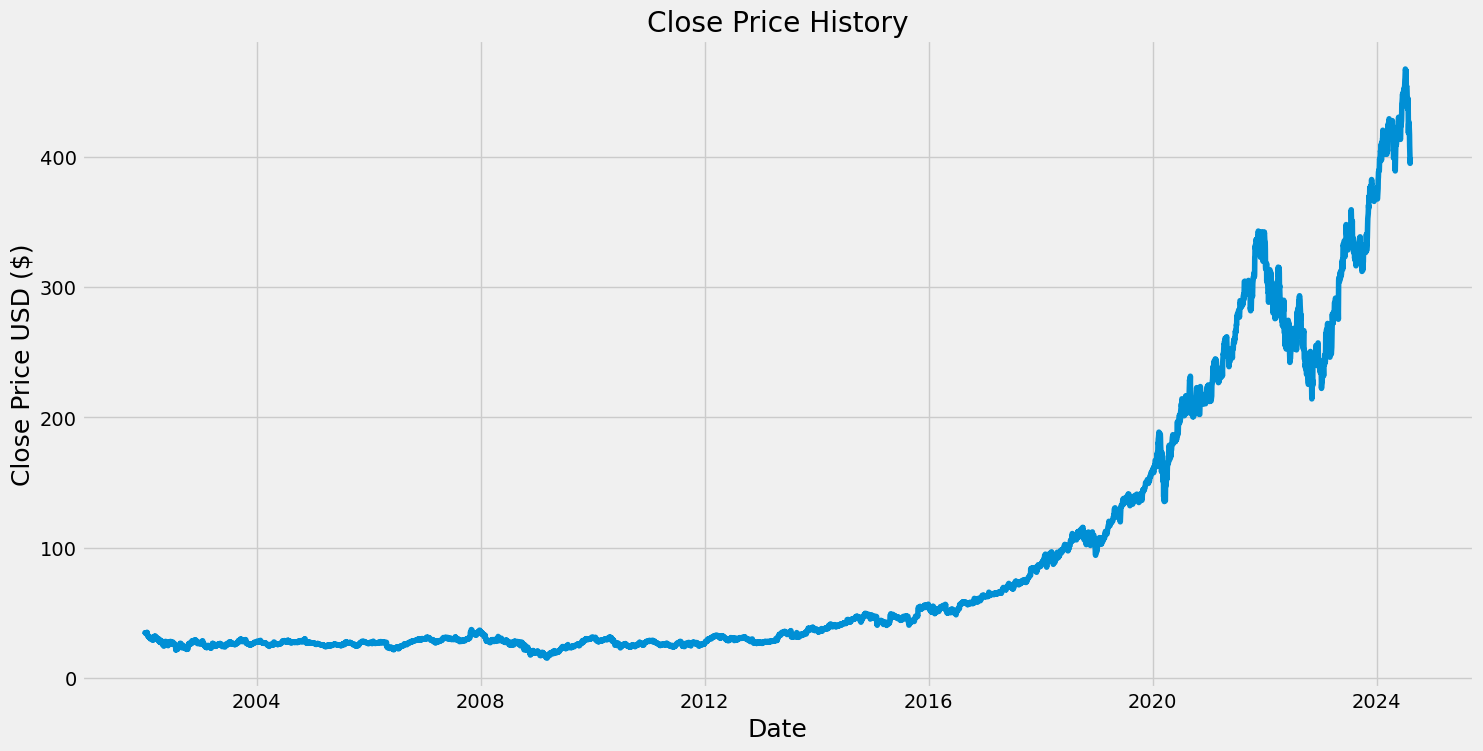

In [9]:
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Prepare the data

## The target variable is the closing price of the stock. 
We will create a new dataframe that contains only the 'Close' column.

In [10]:
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

print(f"Training data length: {training_data_len}")

Training data length: 4550


## Data Preprocessing

## Feature Scaling

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04060476],
       [0.04302514],
       [0.04266042],
       ...,
       [0.86943258],
       [0.83994606],
       [0.84980435]])

## Creating the training data set

In [12]:
train_data = scaled_data[0:training_data_len, :]

## Split the data into a x_train and y_train data set.

X_train will be the past **60 days** stock price while y_train will be the **61st** day stock price.

In [13]:
X_train = []
y_train = []

# This code loops through the data set and creates a data structure with 60 timesteps and 1 output
# So for each day in the dataset, it will create a list of the past 60 days and the 61st day will be the output
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")

X_train length: 4490
y_train length: 4490


## Convert the data into numpy array

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
print(f"X_train shape: {X_train.shape}")

X_train shape: (4490, 60)


## Reshape the data into 3-D array because LSTM model expects the input to be 3-Dimensional.

In [16]:
# makes the data from 2D to 3D
# the parameters are (number of samples, number of time steps, number of features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"X_train shape: {X_train.shape}")

X_train shape: (4490, 60, 1)


## Creating testing data


In [17]:
test_data = scaled_data[training_data_len - 60:, :]

In [18]:
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [19]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(f"X_test shape: {X_test.shape}")

X_test shape: (1137, 60, 1)


## **Build the LSTM model**

In [20]:
model = Sequential([
    # The parameters are (number of units, return_sequences (true because we will use another LSTM), input_shape(Number of time steps, number of features))
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
history = model.fit(X_train, y_train, batch_size=32, epochs=75,
                    verbose=1)

Epoch 1/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0011
Epoch 2/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.2780e-05
Epoch 3/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.1099e-05
Epoch 4/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.2978e-05
Epoch 5/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.1961e-05
Epoch 6/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.2337e-05
Epoch 7/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1264e-05
Epoch 8/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.5063e-05
Epoch 9/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.2437e-05
Epoch 10/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1227e-05
Epoch 11/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.0756e-05
Epoch 12/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.0311e-05
Epoch 13/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.1913e-05
Epoch 14/75
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.

## plot the loss

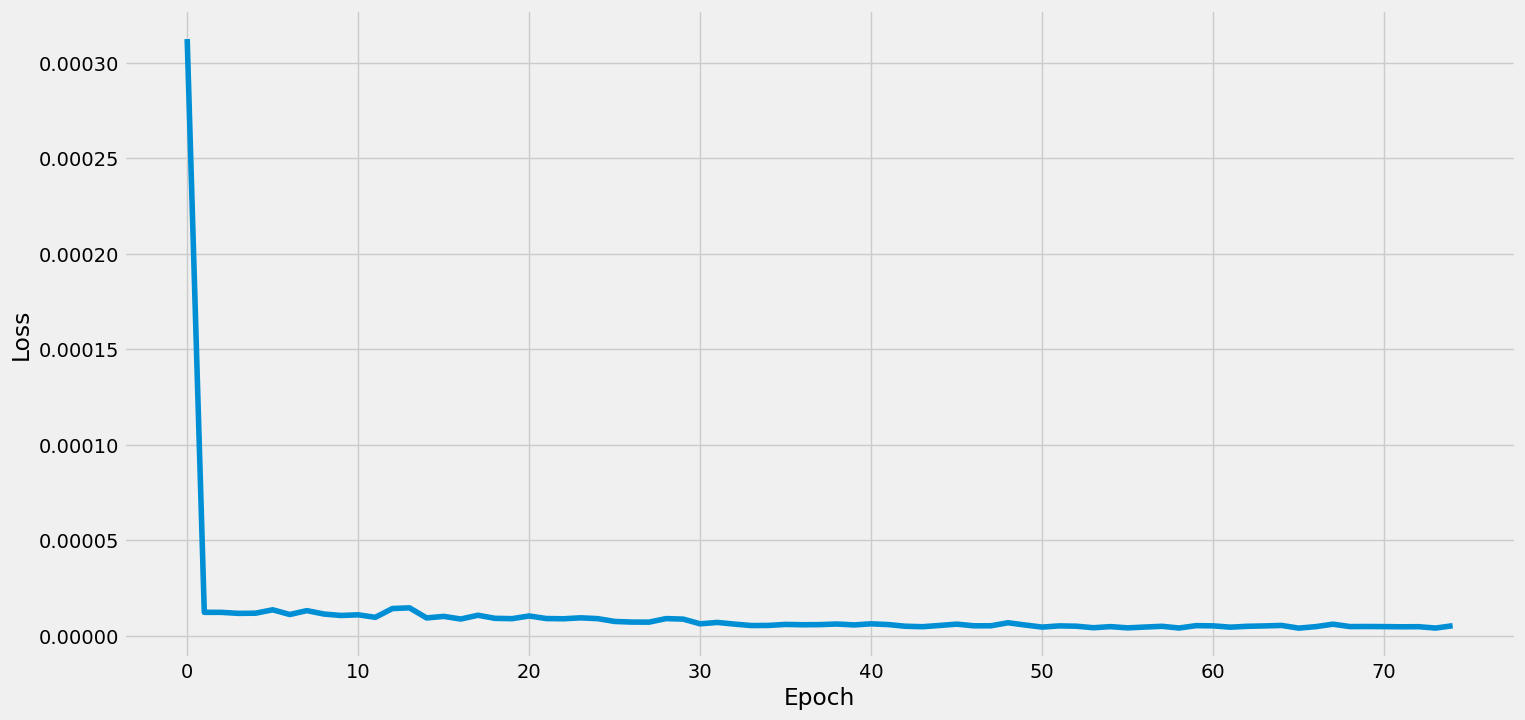

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Predict the test data

In [25]:
predictions = model.predict(X_test)
# We need to inverse the scaling
predictions = scaler.inverse_transform(predictions)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


## Evaluate the model

use the root mean squared error (RMSE) to evaluate the model

In [26]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 5.11687600492456


## Visualize the stock price prediction

In [27]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

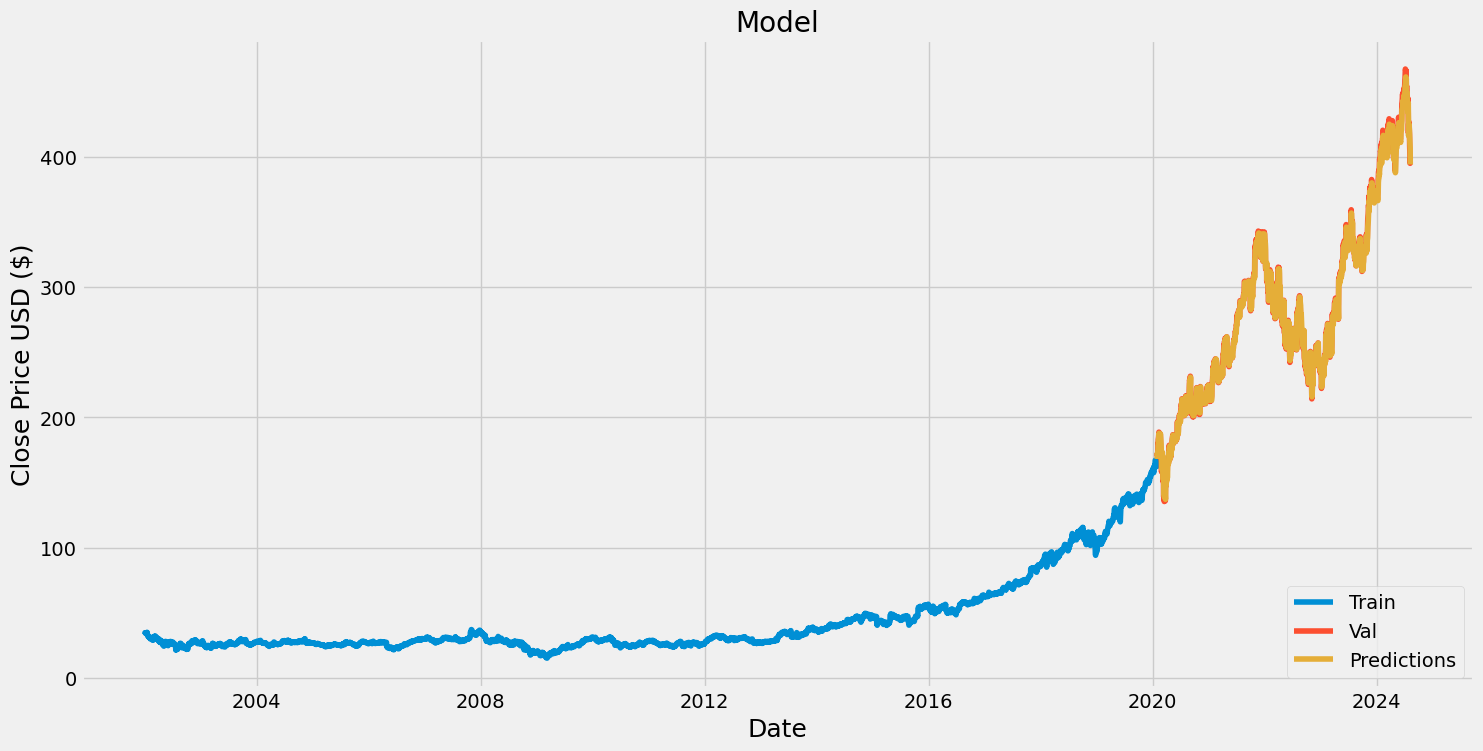

In [28]:
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Show actual price VS predicted price

In [29]:
valid

,Close,Predictions
Date,,
2020-01-30,172.779999,168.153564
2020-01-31,170.229996,172.624588
2020-02-03,174.380005,170.495148
2020-02-04,180.119995,173.967972
2020-02-05,179.899994,179.452820
...,...,...
2024-07-31,418.350006,420.919098
2024-08-01,417.109985,416.294342
2024-08-02,408.489990,414.908966


## Predict future stock price

get the last 60 days closing price and convert the dataframe to a numpy array

In [30]:
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

create an empty list and append the past 60 days price to it

In [31]:
X_test = []
X_test.append(last_60_days_scaled)

Convert the past 60 days price to a numpy array

In [32]:
X_test = np.array(X_test)

reshape the data

In [33]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

get the predicted price and undo the scaling

In [34]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [35]:
print(f"Predicted price for the next day: {pred_price}")

Predicted price for the next day: [[398.337]]


In [36]:
future_quote = yf.download('MSFT', start='2024-08-08', end='2024-08-09')
print("Actual Closing Price:", future_quote["Close"].values)

[*********************100%%**********************]  1 of 1 completed

Actual Closing Price: [403.00500488]
